## GPT Detection: Native vs. Non-Native English Speakers


### Summary
* The notebook below independently confirms the finding of a 2023 CellPress Patterns [publication](https://doi.org/10.1016/j.patter.2023.100779) that detectors used to distinguish whether text was AI-generated or human-generated perform better on texts written by native English speakers than they do on texts by non-native English speakers, whose writings are much more likely to be deemed AI-generated by the detectors evaluated.
* This finding raises ethical questions, as the application of these detectors risks harming contributions of non-native English speakers, particularly when such detectors are used in evaluative settings.
* This analysis extends the findings furnished in the published paper and its supplements with a detailed view at the performance of individual detectors and their performance on texts written by native and non-native English speakers. It also contextualizes these findings relative to detector performance on AI-generated texts.

### Background

In July 2023, a team of researchers (Weixin Liang, Mert Yuksekgonul, Yining Mao, Eric Wu, James Zou) at Stanford University published a paper in CellPress Patterns entitled ["GPT detectors are biased against non-native English writers"](https://doi.org/10.1016/j.patter.2023.100779). The authors highlight that detectors enlisting detectors to distinguish between content that is AI-generated from content that is human-generated is a natural step in an effort to flag or identify AI-generated content that may be used to spread false information. However, the reliability, fairness, and robustness of the classifications output by these detectors remain underexplored.

Specifically, the study examines the performance of detectors on native vs. non-native English speakers. The authors write that, " Our findings reveal that these detectors consistently misclassify non-native English writing samples as AI-generated, whereas native writing samples are accurately identified." The finding that these detectors perform worse on non-native English speakers and tend to classify text from non-native speakers as AI-generated raises a number of ethical questions, including how such speakers may be inadvertantly penalized (e.g., in academic contexts via automated scans that flag plagiarised or AI-generated text) through the use of these technologies.

### Motivation / Goal

There are two main goals for this exercise. First, I attempt to independently replicate the authors' findings from the underlying data. Second, I hope to explore the paper's findings in greater depth than summarized in text and available furnished supplements.


### Data Source, Preview, and Overview

The data associated with the paper was published in a [package](https://cran.r-project.org/package=detectors) on CRAN.
The data has been exported from `R` and imported below.

In [1]:
# Imports

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, accuracy_score, recall_score,
                             roc_curve, auc, log_loss)
# import numpy as np

In [2]:
# import pandas as pd

detectors_df = pd.read_csv('detectors.csv')
detectors_df = detectors_df.drop(detectors_df.columns[0], axis = 1)

In [3]:
detectors_df

,kind,.pred_AI,.pred_class,detector,native,name,model,document_id,prompt
0,Human,9.999942e-01,AI,Sapling,No,Real TOEFL,Human,497,NaN
1,Human,8.281448e-01,AI,Crossplag,No,Real TOEFL,Human,278,NaN
2,Human,2.137465e-04,Human,Crossplag,Yes,Real College Essays,Human,294,NaN
3,AI,0.000000e+00,Human,ZeroGPT,NaN,Fake CS224N - GPT3,GPT3,671,Plain
4,AI,1.784091e-03,Human,OriginalityAI,NaN,"Fake CS224N - GPT3, PE",GPT4,717,Elevate using technical
...,...,...,...,...,...,...,...,...,...
6180,AI,3.723411e-03,Human,HFOpenAI,NaN,Fake CS224N - GPT3,GPT3,662,Plain
6181,AI,6.788506e-02,Human,GPTZero,NaN,Fake CS224N - GPT3,GPT3,583,Plain
6182,Human,1.044658e-17,Human,GPTZero,Yes,US 8th grade essay,Human,151,NaN
6183,AI,9.257823e-01,AI,GPTZero,NaN,Fake College Essays - GPT3,GPT3,423,Plain


Data Overview

* `kind` - The true author of the text (i.e., `Human` or `AI`)
* `.pred_AI` - GPT predictor probability that the text was authored by AI
* `.pred_class` - GPT predictor classification (threshold at 0.5)
* `detector` - Detector name
* `native` - Whether the text was authored by a native English speaker, `NA` for AI-authored texts
* `name` - The source of the text
* `model` - Either `Human` or the specifical model generating text 
* `document_id` - ID for the text
* `prompt` - The prompt used to generate the text for AI-authored texts

In [4]:
detectors_df.shape

(6185, 9)

### EDA

#### Which detectors were used?

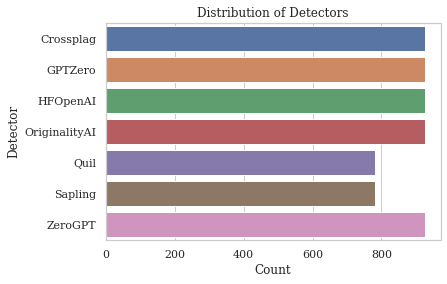

In [5]:
# import matplotlib.pyplot as plt
# import seaborn as sns

%matplotlib inline

detector_counts = detectors_df.groupby('detector').size()

sns.set_theme(style = "whitegrid", font="serif", palette="deep")

sns.barplot(y = detector_counts.index, x = detector_counts.values)
plt.title('Distribution of Detectors')
plt.xlabel('Count')
plt.ylabel('Detector')
plt.show()

#### What models authored the texts used in this study?

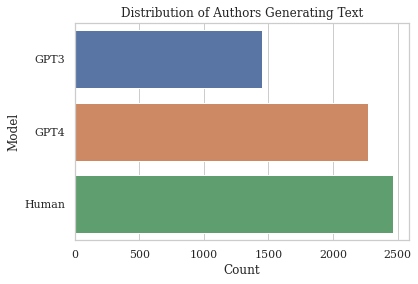

In [6]:
author_counts = detectors_df.groupby('model').size()

sns.barplot(y = author_counts.index, x = author_counts.values)
plt.title('Distribution of Authors Generating Text')
plt.xlabel('Count')
plt.ylabel('Model')
plt.show()

### Analysis of Predicted Classifications

#### Does the aggregate data support the authors' findings that texts from non-native speakers tend to be more often classified as AI-generated relative to texts from native speakers?

In [7]:
(detectors_df.
    groupby(['native', 'kind', '.pred_class'], dropna = False).
    size().
    to_frame('n').
 reset_index())

,native,kind,.pred_class,n
0,No,Human,AI,390
1,No,Human,Human,247
2,Yes,Human,AI,59
3,Yes,Human,Human,1772
4,NaN,AI,AI,1158
5,NaN,AI,Human,2559


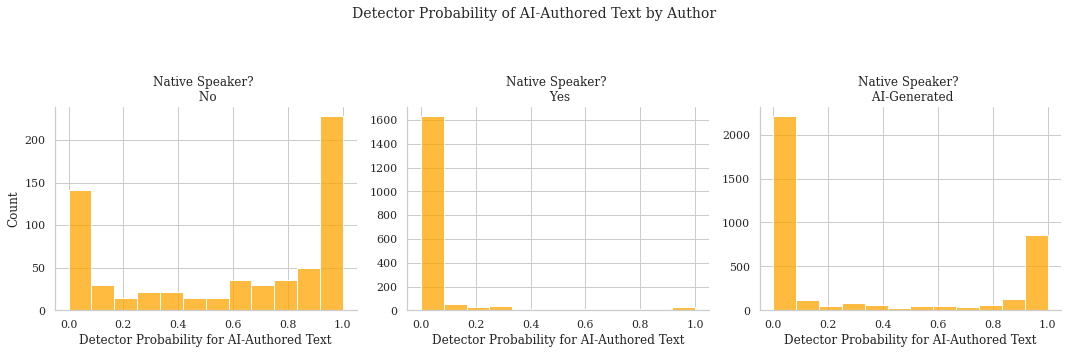

In [8]:
# import numpy as np

detectors_df['native'] = detectors_df['native'].fillna('AI-Generated')

g = sns.FacetGrid(detectors_df, 
                  col = 'native', # Facet variable
                  # col_wrap = 1,  # Output one col
                  sharey = False,
                  height = 5) 

# bins = np.histogram_bin_edges(human_df['.pred_AI'], bins = 'auto') # Auto-define bins 

g.map(sns.histplot, '.pred_AI', bins = 12, color = 'orange') 

g.set_axis_labels("Detector Probability for AI-Authored Text", "Count")
g.set_titles("Native Speaker? \n {col_name}")
g.fig.suptitle("Detector Probability of AI-Authored Text by Author", 
               fontsize = 14)
g.tight_layout(rect=[0, 0, 1, 0.90]) # Visual buffer

# Render plot
plt.show()

We can see that the detectors overwhelmingly conclude that text written by native speakers (middle) is not AI-generated, but text by non-native speakers (left) is deemed more ambiguous and often incorrectly predicted to be AI-generated. In fact, by considering the masses at 0 and 1, the detectors appear more likely to strongly deem texts by non-native English speakers as AI-generated than actual AI-generated texts (right).

#### How robustly do the generators classify text from different authors?

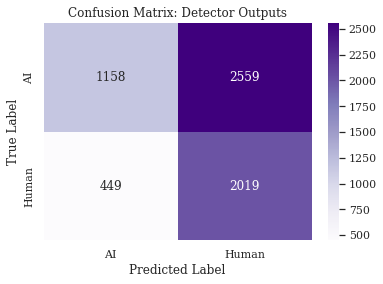

In [9]:
# from sklearn.metrics import confusion_matrix

cfn_matrix = confusion_matrix(detectors_df['kind'], detectors_df['.pred_class'])
# print(cfn_matrix)
lbl = ['AI', 'Human']

sns.heatmap(cfn_matrix, annot=True, fmt = 'd', cmap = 'Purples', 
            xticklabels= lbl,
            yticklabels= lbl)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Detector Outputs')
plt.show()

The detectors perform more accurately identify the true source of human-generated texts than they do AI-generated texts. In other words, the detectors are better at identifying that human documents are written by humans than the are at spotting AI-generated texts to have been written by AI.

In [10]:
# from sklearn.metrics import accuracy_score

accuracy = accuracy_score(detectors_df['kind'], detectors_df['.pred_class'])
# accuracy = cfn_matrix.diagonal().sum() / cfn_matrix.sum()
print(f"Classifier Accuracy: {accuracy:.3f}")

Classifier Accuracy: 0.514


The accuracy of the detectors across all texts is not much better than random guessing. 

Are some detectors more accurate than others?

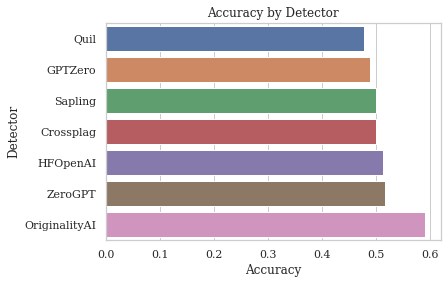

In [11]:
def accuracy_by_group(grp):
    return accuracy_score(grp['kind'], grp['.pred_class'])

detector_acc = detectors_df.groupby('detector').apply(accuracy_by_group).sort_values()
# print(detector_acc)

sns.barplot(y = detector_acc.index, x = detector_acc.values)
plt.title('Accuracy by Detector')
plt.xlabel('Accuracy')
plt.ylabel('Detector')
plt.show()

The detectors `GPTZero` and `Quil` perform worse than random guessing, and `Sapling` is accurate as a coin flip.

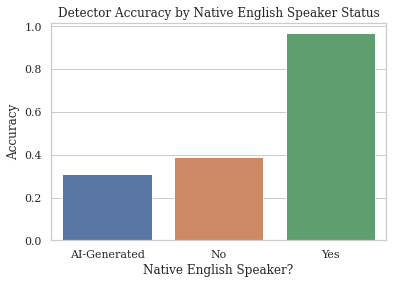

In [12]:
native_acc = detectors_df.groupby('native').apply(accuracy_by_group).sort_values()

sns.barplot(x = native_acc.index, y = native_acc.values)
plt.title('Detector Accuracy by Native English Speaker Status')
plt.xlabel('Native English Speaker?')
plt.ylabel('Accuracy')
plt.show()

# print(native_acc)

The detectors accurately classify the author of texts written by native English speakers nearly 97% of the time but are much worse when written by non-native English speakers (about 38% accuracy). 

It seems reasonable to suppose that the costs here are not symmetric. The cost of identifying an AI-generated text as human-generated, for instance, may be less than the cost of identifying a human-generated text as AI-generated.

In [13]:
# from sklearn.metrics import recall_score

def get_sensitivity_specificity(true, pred, pos_label = 'AI'):  
    tn, fp, fn, tp = confusion_matrix(true, pred, labels=['Human', 'AI']).ravel()
    sensitivity = recall_score(true, pred, pos_label = pos_label)
    specificity = tn / (tn + fp)
    return sensitivity, specificity

get_sensitivity_specificity(detectors_df['kind'], detectors_df['.pred_class'])

(0.3115415657788539, 0.8180713128038898)

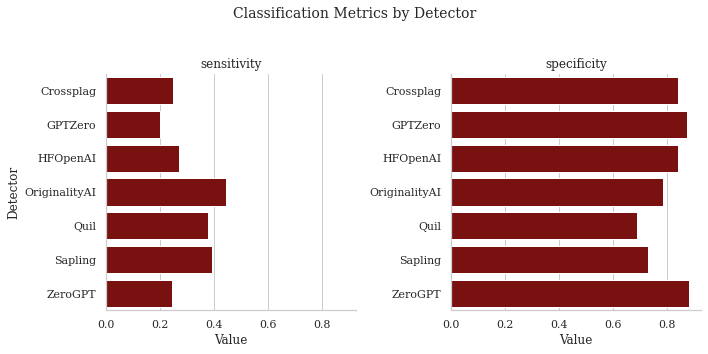

In [14]:
def sens_spec_by_group(grp):
    return get_sensitivity_specificity(grp['kind'], grp['.pred_class'], pos_label = 'AI')

detector_sens_spec = detectors_df.groupby('detector').apply(sens_spec_by_group)
detector_sens_spec = detector_sens_spec.to_frame()
# unpack tuple to separate cols
detector_sens_spec[['sensitivity', 'specificity']] = pd.DataFrame(detector_sens_spec[0].tolist(), index=detector_sens_spec.index)
detector_sens_spec = detector_sens_spec.drop(columns=0)  # Drop orig tuple colum
detector_sens_spec = detector_sens_spec.reset_index()

detector_sens_spec = pd.melt(detector_sens_spec, id_vars=['detector'], var_name='metric', value_name='value')
categories = detector_sens_spec['detector'].unique()

h = sns.FacetGrid(detector_sens_spec, 
                  col = 'metric', # Facet variable
                  sharey = False,
                  height = 5)
h.map(sns.barplot, 'value', 'detector', order = categories, color = 'DarkRed')
h.set_titles("{col_name}")
h.fig.suptitle("Classification Metrics by Detector", 
               fontsize = 14)
h.set_axis_labels("Value", "Detector")
h.tight_layout(rect=[0, 0, 1, 0.95]) # Visual buffer
plt.show()

The detectors vary markedly with respect to both sensitivity and specificity.

### Analysis of Predicted Probabilities

#### Classification Outcomes

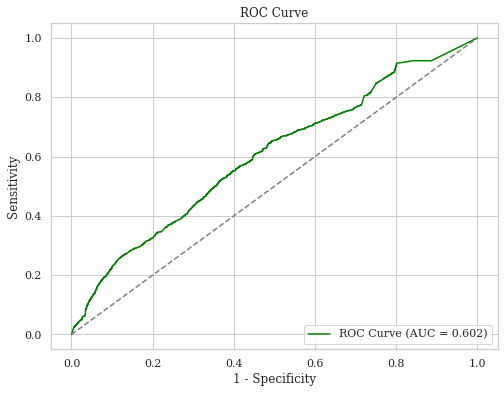

In [15]:
# from sklearn.metrics import roc_curve, auc

# ROC Curve
fpr, tpr, thresholds = roc_curve(detectors_df['kind'],     # truth
                                 detectors_df['.pred_AI'], # pred probabilities
                                 pos_label = 'AI')

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color = 'green', 
         label = f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color = 'gray', 
         linestyle = '--')  # Plot y = x line
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')
plt.show()

As expected, on the whole, the detectors do not fare much better than random guessing. 

How do the ROC Curves differ by detector? The evidence above suggests that some are clearly better than others.

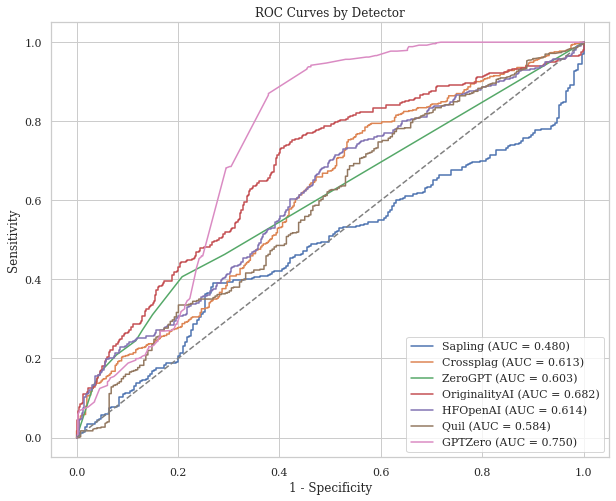

In [16]:
plt.figure(figsize=(10, 8))  

for detector in detectors_df['detector'].unique():
    # Loop through individual detectors
    individual_detector_df = detectors_df[detectors_df['detector'] == detector]
    fpr, tpr, thresholds = roc_curve(individual_detector_df['kind'], 
                                     individual_detector_df['.pred_AI'], 
                                     pos_label = 'AI')
    roc_auc = auc(fpr, tpr)
    
    # Plot detector's ROC Curve
    plt.plot(fpr, tpr, label=f'{detector} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--') # y = x line
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curves by Detector')
plt.legend(loc = 'lower right')
plt.show()

GPTZero (AUC = 0.750) performs far better than Sapling (AUC = 0.480).

#### Log Loss

In [17]:
# from sklearn.metrics import log_loss

# We have .pred_AI but need .pred_Human, the compliment
detectors_df['.pred_Human'] = 1 - detectors_df['.pred_AI']
predicted_probs = detectors_df[['.pred_AI', '.pred_Human']].values

loss = log_loss(detectors_df['kind'],    
                 predicted_probs)
print(f"Mean Log Loss: {loss}")

Mean Log Loss: 4.66245085334123


In [18]:
# Log Loss by Group

def generate_grouped_log_loss(group_of_interest, labels):
    grouped = detectors_df.groupby(group_of_interest)
    
    # Calculate log loss for each group
    log_losses = []
    
    for name, group in grouped:
        true = group['kind']
        predictions = group[['.pred_AI', '.pred_Human']].values
        
        # Group-specific Log Loss
        loss = log_loss(true, predictions, labels = labels)
        
        # Append results to growing list
        log_losses.append({'group': name, 'mean_log_loss': loss})
    
    detector_log_loss_df = pd.DataFrame(log_losses)
    return detector_log_loss_df

In [19]:
generate_grouped_log_loss('detector', labels = ['Human', 'AI'])

,group,mean_log_loss
0,Crossplag,2.811470
1,GPTZero,4.602734
2,HFOpenAI,2.834710
3,OriginalityAI,1.943406
4,Quil,3.182539
5,Sapling,5.821843
6,ZeroGPT,11.390210


In [20]:
generate_grouped_log_loss('native', labels = ['Human', 'AI'])

,group,mean_log_loss
0,AI-Generated,7.089866
1,No,3.566597
2,Yes,0.115950


In [21]:
# Grouping by both 'detector'and 'native'

disagg_log_loss = generate_grouped_log_loss(['detector', 'native'], labels = ['Human', 'AI'])
disagg_log_loss[['detector', 'native']] = pd.DataFrame(disagg_log_loss['group'].tolist(), index=disagg_log_loss.index)
disagg_log_loss = disagg_log_loss.drop('group', axis=1)
# disagg_log_loss

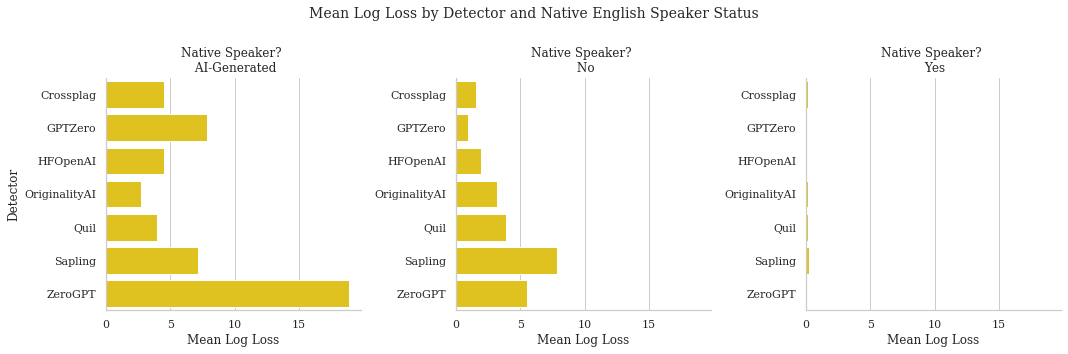

In [22]:
j = sns.FacetGrid(disagg_log_loss, 
                  col = 'native', # Facet variable
                  sharey = False,
                  height = 5)
j.map(sns.barplot, 'mean_log_loss', 'detector', 
      order = categories,
      color = 'Gold')
j.set_titles("Native Speaker? \n {col_name}")
j.fig.suptitle("Mean Log Loss by Detector and Native English Speaker Status", 
               fontsize = 14)
j.set_axis_labels("Mean Log Loss", "Detector")
j.tight_layout(rect=[0, 0, 1, 0.98]) # Visual buffer
plt.show()

There are a few noteworthy findings here. First, as the data above suggested, the models perform far better on classifying texts written by native English speakers than they do on non-native English speakers, which are clasified with greater fidelity than AI-generated texts are.

Interestingly, the models deemed best with respect to pure classification performance do not appear to be the best models when accounting for the 'confidence' of the prediction, as log loss takes into account. For example, GPTZero (AUC = 0.750) performs far better than OriginalityAI (AUC = 0.682). However, when considering the average log loss of both detectors, GPTZero performs far worse (11.39 vs. 1.94). This suggests, for instance, that the classification outcomes output by GPTZero are relatively strong but that the classification probabilities output by the model are not well calibrated. It is also possible, for example, that the detector outputs predictions that are confident but incorrect in some cases. 

**In addition to extending the details furnished in the paper, the findings above confirm its major finding that the detectors studied here perform worse at identifying human-authored text when written by non-native English speakers relative to native speakers.**

### Future Work

The remaining parts of the paper (not described above) illustrate that simply instructing ChatGPT to edit the texts in question to employ more advanced language circumvents the detection problems outlined above. The fact detectors perform poorly on text from non-native speakers and that the detectors can be bypassed so easily both demonstrate the need for more fair and robust AI-generated content detectors.

The authors also mention that future work conduct similar tests with a larger sample size (more subjects, greater diversity of texts) and with newer GPTs. The detectors studied in the paper used GPT-2 for its tractability, but it is possible that more recent generations of GPTs may solve the problems outlined above. Of course, asessing whether these findings generalize to native and non-native speakers of other languages is a natural extension of this work. 

### Recommendations

1. The authors recommend against the use of AI-content detectors, particularly in evaluative settings when applied to the work of non-native English speakers.
2. Since detection methods that depend upon language complexity fail basic robustness checks, watermarking and more detailed perplexity checks (e.g., second-order perplexity methods) should be employed to detect AI-generated content.